In [4]:
from pubg_util import mysql, load_schema, notifier
from sphynx import sphynx, NODE_SMALL, NODE_MEDIUM, NODE_LARGE
from pyspark.sql.functions import *

spark = sphynx.get_spark(executor_count=4, app_name='pdu_syp', node_spec=NODE_MEDIUM)

Spark cluster not assigned. creating a new one...
Node spec: 4 executors with 24G RAM each
Job Port 4049 is assigned for requested cluster
Waiting for Spark master to be available...
Spark master launched!
Creating new Spark session, name: pdu_syp...
Waiting for all executors ready...
All executors connected!
Complete! elapsed time: 00:00:26


In [2]:
sphynx.stop()

#### PGC 2021
- 2021-11-12 ~ 2021-12-18 (37일)
- 분석 기간: 2021-09-11 ~ 2021-10-17 (37일)

In [6]:
start_date = '2021-09-11'
end_date = '2021-10-17'

### PC

In [7]:
user_pc = load_data_mart(start_date=start_date, end_date=end_date, device='pc', table_name='user_master')
gcoin_pc = load_data_mart(start_date=start_date, end_date=end_date, device='pc', table_name='gcoin_use')

In [40]:
gcoin_pc.select('price', 'price_').show(10)

+-----+-------+
|price| price_|
+-----+-------+
|  200| 200.00|
|  510|1290.00|
| 1800|1800.00|
| 1800|1800.00|
|  400| 400.00|
|  990| 990.00|
|  100| 100.00|
| 1800|1800.00|
| 1800|1800.00|
|  500| 500.00|
+-----+-------+
only showing top 10 rows



주어진 27일 데이터간 au, pu, revenue

In [240]:
user_pc.where("lastlogindate >= '2021-09-11' ").select('accountid').distinct().count()

7146056

In [239]:
gcoin_pc.select(countDistinct('account_id'), sum('price')).show()

+--------------------------+----------+
|count(DISTINCT account_id)|sum(price)|
+--------------------------+----------+
|                   1088092|4202814860|
+--------------------------+----------+



In [256]:
gcoin_pc.count()

5204924

In [244]:
product_price = gcoin_pc.groupBy('product_name', 'price').agg(countDistinct('account_id'), count("*"), sum('price')).toPandas()

In [245]:
product_price.shape

(681, 5)

In [249]:
product_price.sort_values('price', ascending=False).head(10)

,product_name,price,count(DISTINCT account_id),count(1),sum(price)
183,BLACKPINK MEGA BUNDLE,9900,5235,5235,51826500
236,SPACE BUNNY ULTIMATE BUNDLE,5440,33357,33357,181462080
640,PCS5 ULTIMATE BUNDLE,3960,10706,10706,42395760
159,SURVIVOR PASS: CRAZY NIGHT WEAPON & LEVEL PACK,3270,18060,18060,59056200
575,JENNIE'S BLACKPINK BUNDLE,2780,10265,10265,28536700
371,LISA'S BLACKPINK BUNDLE,2780,4454,4454,12382120
383,JISOO'S BLACKPINK BUNDLE,2780,8519,8519,23682820
395,ROSÉ'S BLACKPINK BUNDLE,2780,8766,8766,24369480
420,FLOWER POWER WEAPON BUNDLE,2770,125,125,346250
553,SON HEUNG-MIN'S OUTFIT BUNDLE,2530,1368,1368,3461040


- mega bundle 혹은 bundle 같은 경우 한사람당 한번씩만 구매

In [266]:
gcoin_pc.where(col('product_name').like("%BUNDLE%")).withColumn("over3000", when(col("price") >= 3000, 1).otherwise(0)).select(countDistinct("account_id"), sum("over3000")).show()

+--------------------------+-------------+
|count(DISTINCT account_id)|sum(over3000)|
+--------------------------+-------------+
|                    213898|        49298|
+--------------------------+-------------+



In [250]:
bundle_product_price = gcoin_pc.where(col('product_name').like('%BUNDLE%')).groupBy('product_name', 'price').agg(countDistinct('account_id'), count("*"), sum("price")).toPandas()

In [251]:
bundle_product_price.shape

(112, 5)

In [254]:
bundle_product_price.sort_values('price', ascending=False).head()

,product_name,price,count(DISTINCT account_id),count(1),sum(price)
30,BLACKPINK MEGA BUNDLE,9900,5235,5235,51826500
40,SPACE BUNNY ULTIMATE BUNDLE,5440,33357,33357,181462080
108,PCS5 ULTIMATE BUNDLE,3960,10706,10706,42395760
57,LISA'S BLACKPINK BUNDLE,2780,4454,4454,12382120
58,JISOO'S BLACKPINK BUNDLE,2780,8519,8519,23682820


In [257]:
bundle_product_price.sum()

product_name                  FESTIVE FLANNEL WEAPON BUNDLEFAIRIED AWAY BUND...
price                                                                    157530
count(DISTINCT account_id)                                               252829
count(1)                                                                 252831
sum(price)                                                            598669130
dtype: object

In [255]:
bundle_product_price[bundle_product_price.price >= 3000].sum()

product_name                  BLACKPINK MEGA BUNDLESPACE BUNNY ULTIMATE BUND...
price                                                                     19300
count(DISTINCT account_id)                                                49298
count(1)                                                                  49298
sum(price)                                                            275684340
dtype: object

In [259]:
product_price.sum()

product_name                  Animal House - AKMStriped Graffiti Pink - Helm...
price                                                                    520450
count(DISTINCT account_id)                                              3048552
count(1)                                                                5204924
sum(price)                                                           4202814860
dtype: object

In [ ]:
gcoin_pc.groupBy('account_id').agg(count("*"), countDistinct(when(col('product_name').like('%BUNDLE%')), col('transaction_id'))).show(10)

In [ ]:
pay_time_per_user = gcoin_pc.groupBy('account_id').agg(count("*"), countDistinct(when(col('product_name').like('%BUNDLE%')), col('transaction_id'))).toPandas()

In [192]:
gcoin_pc_daily_use = gcoin_pc.groupBy('date', 'account_id').agg(sum('price').alias('gcoin_daily_use'), 
                                                                min('price').alias('min_gcoin'), 
                                                                avg('price').alias('avg_gcoin'), 
                                                                max('price').alias('max_gcoin'),
                                                                countDistinct('transaction_id').alias('trans_time'))

In [74]:
gcoin_pc_daily_use.count()

2431095

In [194]:
gcoin_pc_daily_use_pd = gcoin_pc_daily_use.toPandas()

In [84]:
gcoin_pc_daily_use_pd.head()

,date,account_id,gcoin_daily_use,min_gcoin,avg_gcoin,max_gcoin,trans_time
0,2021-10-08,account.466510fdb1724e50a19ecd7d8f116f00,3090,200,441.428571,1590,7
1,2021-09-26,account.1b96ad0279ac4cbb9401dd170b099739,1590,1590,1590.000000,1590,1
2,2021-09-19,account.3946b2a66021440e908d6493dd319e60,15200,200,1266.666667,1800,12
3,2021-09-21,account.1e76199e59d34bb28c8625440d62bc60,1100,200,275.000000,500,4
4,2021-09-11,account.5813bdd50a6647a58f4d7607059bccbb,1190,200,595.000000,990,2


한 유저당 하루에 사용하는 gcoin의 정도

In [89]:
gcoin_pc_daily_use_pd.describe().round(2)

,gcoin_daily_use,min_gcoin,avg_gcoin,max_gcoin,trans_time
count,2431095.00,2431095.00,2431095.00,2431095.00,2431095.00
mean,1728.77,534.91,643.04,786.31,2.14
std,5871.10,684.33,728.93,961.86,4.09
min,100.00,100.00,100.00,100.00,1.00
25%,200.00,200.00,200.00,200.00,1.00
50%,500.00,250.00,390.00,480.00,1.00
75%,1190.00,590.00,910.00,990.00,2.00
max,280800.00,9900.00,9900.00,9900.00,365.00


In [142]:
gcoin_pc_daily_use.columns

['date',
 'account_id',
 'gcoin_daily_use',
 'min_gcoin',
 'avg_gcoin',
 'max_gcoin',
 'trans_time']

In [144]:
gcoin_pc_daily_use.printSchema()

root
 |-- date: string (nullable = true)
 |-- account_id: string (nullable = true)
 |-- gcoin_daily_use: long (nullable = true)
 |-- min_gcoin: long (nullable = true)
 |-- avg_gcoin: double (nullable = true)
 |-- max_gcoin: long (nullable = true)
 |-- trans_time: long (nullable = false)



하루 500 ~ 1000 코인 소비하는 유저들

In [197]:
gcoin_pc_daily_use_pd[(gcoin_pc_daily_use_pd.gcoin_daily_use >= 500) & (gcoin_pc_daily_use_pd.gcoin_daily_use <=1000)].describe()

,gcoin_daily_use,min_gcoin,avg_gcoin,max_gcoin,trans_time
count,657750.000000,657750.000000,657750.000000,657750.000000,657750.000000
mean,756.467168,617.220084,632.652367,649.654534,1.475719
std,203.726916,295.462984,277.669412,265.456107,0.936973
min,500.000000,100.000000,100.000000,100.000000,1.000000
25%,590.000000,490.000000,500.000000,500.000000,1.000000
50%,710.000000,590.000000,590.000000,590.000000,1.000000
75%,990.000000,990.000000,990.000000,990.000000,2.000000
max,1000.000000,1000.000000,1000.000000,1000.000000,9.000000


In [165]:
x = gcoin_pc_daily_use_pd.groupby('date')['account_id'].count().reset_index(name='account_cnt').sort_values('date')
y = gcoin_pc_daily_use_pd[(gcoin_pc_daily_use_pd.gcoin_daily_use >= 500) & (gcoin_pc_daily_use_pd.gcoin_daily_use <=1000)].groupby('date')['account_id'].count().reset_index(name='account_cnt_').sort_values('date')
z = pd.merge(x, y, on='date')
z['p'] = z['account_cnt_']/z.account_cnt
z

,date,account_cnt,account_cnt_,p
0,2021-09-11,57807,23433,0.405366
1,2021-09-12,47211,18929,0.400945
2,2021-09-13,35031,13449,0.383917
3,2021-09-14,31086,11707,0.376600
4,2021-09-15,33523,11731,0.349939
5,2021-09-16,32263,11593,0.359328
6,2021-09-17,80685,19291,0.239090
7,2021-09-18,56726,17159,0.302489
8,2021-09-19,48977,15885,0.324336
9,2021-09-20,42711,14220,0.332935


In [167]:
z.round(2).to_csv('500_1000.csv', index=False)

500~1000 gcoin 상품 구매

In [175]:
a = gcoin_pc.where('price >= 500 and price <= 1000').groupBy('date').agg(countDistinct('account_id').alias('500_1000'))
b = gcoin_pc.groupBy('date').agg(countDistinct('account_id').alias('cnt'))
c = a.join(b, 'date').withColumn('p', col('500_1000')/col('cnt'))
c

DataFrame[date: string, 500_1000: bigint, cnt: bigint, p: double]

In [176]:
c.orderBy('date').show()

+----------+--------+------+-------------------+
|      date|500_1000|   cnt|                  p|
+----------+--------+------+-------------------+
|2021-09-11|   33279| 57807| 0.5756915252478073|
|2021-09-12|   26337| 47211| 0.5578572790239563|
|2021-09-13|   18596| 35031| 0.5308441095030116|
|2021-09-14|   15936| 31086| 0.5126423470372515|
|2021-09-15|   16031| 33523| 0.4782089908421084|
|2021-09-16|   15889| 32263|0.49248365000154976|
|2021-09-17|   42901| 80685|  0.531709735390717|
|2021-09-18|   30671| 56726| 0.5406868102809999|
|2021-09-19|   26137| 48977| 0.5336586561038855|
|2021-09-20|   22748| 42711| 0.5326028423591113|
|2021-09-21|   20592| 39139| 0.5261248371189862|
|2021-09-22|   16836| 34318| 0.4905880296054549|
|2021-09-23|   14720| 29134| 0.5052515960733164|
|2021-09-24|   14859| 29242| 0.5081389781820669|
|2021-09-25|   16225| 31515| 0.5148342059336823|
|2021-09-26|   13943| 27107| 0.5143689821817243|
|2021-09-27|   12307| 24191| 0.5087429209210037|
|2021-09-28|   14575

In [178]:
c.orderBy('date').toPandas().round(3).to_csv('small_purchase.csv', index=False)

하루에 5000 지코인 이상 소비하는 유저들

In [152]:
a = gcoin_pc_daily_use_pd.groupby('date')['account_id'].count().reset_index(name='account_cnt').sort_values('date')
b = gcoin_pc_daily_use_pd[gcoin_pc_daily_use_pd.gcoin_daily_use >= 5000].groupby('date')['account_id'].count().reset_index(name='account_cnt_5000').sort_values('date')
c = pd.merge(a, b, on='date')
c['p'] = c.account_cnt_5000/c.account_cnt
c

,date,account_cnt,account_cnt_5000,p
0,2021-09-11,57807,6199,0.107236
1,2021-09-12,47211,4421,0.093643
2,2021-09-13,35031,3486,0.099512
3,2021-09-14,31086,3056,0.098308
4,2021-09-15,33523,3448,0.102855
5,2021-09-16,32263,3161,0.097976
6,2021-09-17,80685,16994,0.210622
7,2021-09-18,56726,8269,0.145771
8,2021-09-19,48977,5989,0.122282
9,2021-09-20,42711,4951,0.115919


In [153]:
c.to_csv('pay_5000.csv', index=False)

5000 이상 되는 상품 구매

In [179]:
a = gcoin_pc.where('price >= 5000').groupBy('date').agg(countDistinct('account_id').alias('5000'))
b = gcoin_pc.groupBy('date').agg(countDistinct('account_id').alias('cnt'))
c = a.join(b, 'date').withColumn('p', col('5000')/col('cnt'))

In [180]:
c.orderBy('date').show()

+----------+-----+------+--------------------+
|      date| 5000|   cnt|                   p|
+----------+-----+------+--------------------+
|2021-09-11|  365| 57807|0.006314114207621...|
|2021-09-12|  244| 47211|0.005168287051746415|
|2021-09-13|  191| 35031|0.005452313665039537|
|2021-09-14|  169| 31086|0.005436530914237921|
|2021-09-15|  200| 33523|0.005966053157533...|
|2021-09-16|  206| 32263|0.006385023091467006|
|2021-09-17|12909| 80685| 0.15999256367354528|
|2021-09-18| 4745| 56726| 0.08364771004477664|
|2021-09-19| 2888| 48977|  0.0589664536415052|
|2021-09-20| 2079| 42711| 0.04867598510922245|
|2021-09-21| 1528| 39139| 0.03904034339150208|
|2021-09-22| 1312| 34318| 0.03823066612273442|
|2021-09-23|  889| 29134| 0.03051417587698222|
|2021-09-24|  820| 29242|0.028041857602079202|
|2021-09-25|  778| 31515|0.024686657147390132|
|2021-09-26|  603| 27107| 0.02224517652266942|
|2021-09-27|  591| 24191|0.024430573353726594|
|2021-09-28|  570| 34449|0.016546198728555256|
|2021-09-29| 

In [183]:
c.orderBy('date').toPandas().round(5).to_csv('5000.csv', index=False)

BUNDLE 구매 정도

In [132]:
gcoin_pc.where("lower(product_name) like '%bundle%' ").select('product_name', 'price').distinct().orderBy("price", ascending=False).show(truncate=False)

+-----------------------------------------+-----+
|product_name                             |price|
+-----------------------------------------+-----+
|BLACKPINK MEGA BUNDLE                    |9900 |
|SPACE BUNNY ULTIMATE BUNDLE              |5440 |
|PCS5 ULTIMATE BUNDLE                     |3960 |
|JISOO'S BLACKPINK BUNDLE                 |2780 |
|JENNIE'S BLACKPINK BUNDLE                |2780 |
|ROSÉ'S BLACKPINK BUNDLE                  |2780 |
|LISA'S BLACKPINK BUNDLE                  |2780 |
|FLOWER POWER WEAPON BUNDLE               |2770 |
|SON HEUNG-MIN'S OUTFIT BUNDLE            |2530 |
|MOO'D KILLER WEAPON BUNDLE               |2420 |
|FLOWER POWER WEAPON BUNDLE               |2370 |
|MOO'D KILLER WEAPON BUNDLE               |2080 |
|LAUGHING STOCKS BUNDLE                   |2070 |
|COLORFUL CHAOS WEAPON BUNDLE 1           |2070 |
|COLORFUL CHAOS WEAPON BUNDLE 1           |2000 |
|COLORFUL CHAOS WEAPON BUNDLE 2           |2000 |
|MANTICORE YELLOW MOTOCROSS AND AKM BUNDLE|1980 |


In [113]:
bundle = gcoin_pc.where("product_name like '%BUNDLE%' ").groupBy('date').agg(countDistinct('account_id').alias('account_cnt'), 
                                                                             countDistinct('transaction_id').alias('trans_cnt'),
                                                                             countDistinct('product_name').alias('nunique_bundle'),
                                                                             sum('price').alias('sum_price')
                                                                            ).orderBy("date")
bundle_3000 = gcoin_pc.where("product_name like '%BUNDLE%' and price >= 3000").groupBy('date').agg(countDistinct('account_id').alias('3000_account_cnt'), 
                                                                                                   countDistinct('transaction_id').alias('3000_trans_cnt'),
                                                                                                   countDistinct('product_name').alias('3000_nunique_bundle'),
                                                                                                   sum('price').alias('3000_sum_price')
                                                                                                  ).orderBy("date")

In [128]:
bundle.join(bundle_3000, 'date').withColumn('account percentage', round(col('3000_account_cnt')/col('account_cnt')*100, 2)) \
                                .withColumn('trans percentage', round(col('3000_trans_cnt')/col('trans_cnt')*100, 2)) \
                                .withColumn('price percentage', round(col('3000_sum_price')/col('sum_price')*100, 2)) \
                                .orderBy('date').toPandas().to_csv('bundle.csv', index=False)

In [114]:
bundle.join(bundle_3000, 'date').withColumn('account percentage', round(col('3000_account_cnt')/col('account_cnt')*100, 2)) \
                                .withColumn('trans percentage', round(col('3000_trans_cnt')/col('trans_cnt')*100, 2)) \
                                .withColumn('price percentage', round(col('3000_sum_price')/col('sum_price')*100, 2)) \
                                .orderBy('date').show(40)

+----------+-----------+---------+--------------+---------+----------------+--------------+-------------------+--------------+------------------+----------------+----------------+
|      date|account_cnt|trans_cnt|nunique_bundle|sum_price|3000_account_cnt|3000_trans_cnt|3000_nunique_bundle|3000_sum_price|account percentage|trans percentage|price percentage|
+----------+-----------+---------+--------------+---------+----------------+--------------+-------------------+--------------+------------------+----------------+----------------+
|2021-09-11|       3990|     4372|            28| 15518660|            2056|          2078|                  2|      10396980|             51.53|           47.53|            67.0|
|2021-09-12|       3265|     3541|            27| 11959970|            1457|          1473|                  2|       7282440|             44.62|            41.6|           60.89|
|2021-09-13|       2491|     2722|            28|  8810450|             975|           985|         

In [118]:
bundle_pd = bundle.join(bundle_3000, 'date').withColumn('account percentage', round(col('3000_account_cnt')/col('account_cnt')*100, 2)) \
                                .withColumn('trans percentage', round(col('3000_trans_cnt')/col('trans_cnt')*100, 2)) \
                                .withColumn('price percentage', round(col('3000_sum_price')/col('sum_price')*100, 2)) \
                                .orderBy('date').toPandas()

- 값 싼 번들의 개수가 더 많아지면서 비교적 저렴한 번들의 구매량이 더 많아짐
- 

In [106]:
gcoin_pc.where("date == '2021-09-11' and product_name like '%BUNDLE%' ").groupBy('product_name').count().orderBy('product_name').show(30, truncate=False)

+-----------------------------------------+-----+
|product_name                             |count|
+-----------------------------------------+-----+
|BLACKPINK MEGA BUNDLE                    |365  |
|CIRCUS STAR BUNDLE                       |54   |
|CNH'S BUNDLE                             |121  |
|COLORFUL CHAOS WEAPON BUNDLE 1           |5    |
|COLORFUL CHAOS WEAPON BUNDLE 2           |11   |
|ENDURO STUNT SUIT AND UMP BUNDLE         |1    |
|GRAFFITI BACKPACK BUNDLE                 |74   |
|GRAFFITI HELMET BUNDLE                   |16   |
|GROOVY GETUP BUNDLE                      |6    |
|GROOVY OUTFIT BUNDLE                     |11   |
|HIP OUTFIT BUNDLE                        |3    |
|JENNIE'S BLACKPINK BUNDLE                |455  |
|JISOO'S BLACKPINK BUNDLE                 |372  |
|LISA'S BLACKPINK BUNDLE                  |169  |
|LONGSKR'S BUNDLE                         |107  |
|MANTICORE BLACK MOTOCROSS AND SLR BUNDLE |2    |
|MANTICORE YELLOW MOTOCROSS AND AKM BUNDLE|4    |


In [107]:
gcoin_pc.where("date == '2021-10-17' and product_name like '%BUNDLE%' ").groupBy('product_name').count().orderBy('product_name').show(30, truncate=False)

+-----------------------------------------+-----+
|product_name                             |count|
+-----------------------------------------+-----+
|"YEAR OF THE COW" OUTFIT BUNDLE 2        |28   |
|B.A.S.A. BUNNY BUNDLE                    |487  |
|BLACKPINK MEGA BUNDLE                    |92   |
|CIRCUS STAR BUNDLE                       |14   |
|COLORFUL CHAOS WEAPON BUNDLE 1           |3    |
|COLORFUL CHAOS WEAPON BUNDLE 2           |6    |
|ENDURO STUNT SUIT AND UMP BUNDLE         |1    |
|EVENING BLOOM BUNDLE                     |29   |
|FAIRIED AWAY BUNDLE                      |27   |
|FANCY BERYL BUNDLE                       |303  |
|FESTIVE FLANNEL WEAPON BUNDLE            |83   |
|FLOWER POWER WEAPON BUNDLE               |43   |
|GRAFFITI BACKPACK BUNDLE                 |28   |
|GRAFFITI HELMET BUNDLE                   |2    |
|GROOVY GETUP BUNDLE                      |1    |
|GROOVY OUTFIT BUNDLE                     |4    |
|HIP OUTFIT BUNDLE                        |4    |


MEGA BUNDLE

In [116]:
gcoin_pc.where('price >= 5000').select('product_name', 'price').distinct().show()

+--------------------+-----+
|        product_name|price|
+--------------------+-----+
|BLACKPINK MEGA BU...| 9900|
|SPACE BUNNY ULTIM...| 5440|
+--------------------+-----+



In [117]:
gcoin_pc.where('price >= 5000').groupBy('date', 'product_name').agg(
    countDistinct('transaction_id'),
    countDistinct('account_id'),
    sum('price')
).orderBy('date', 'product_name').show(100)

+----------+--------------------+------------------------------+--------------------------+----------+
|      date|        product_name|count(DISTINCT transaction_id)|count(DISTINCT account_id)|sum(price)|
+----------+--------------------+------------------------------+--------------------------+----------+
|2021-09-11|BLACKPINK MEGA BU...|                           365|                       365|   3613500|
|2021-09-12|BLACKPINK MEGA BU...|                           244|                       244|   2415600|
|2021-09-13|BLACKPINK MEGA BU...|                           191|                       191|   1890900|
|2021-09-14|BLACKPINK MEGA BU...|                           169|                       169|   1673100|
|2021-09-15|BLACKPINK MEGA BU...|                           200|                       200|   1980000|
|2021-09-16|BLACKPINK MEGA BU...|                           206|                       206|   2039400|
|2021-09-17|BLACKPINK MEGA BU...|                           229|         

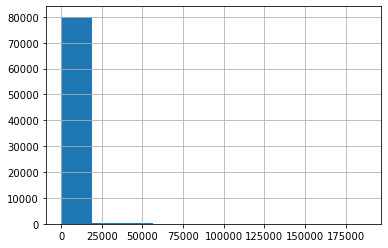

In [80]:
gcoin_pc_daily_use_pd[gcoin_pc_daily_use_pd.date == '2021-09-17']['gcoin_daily_use'].hist()

In [30]:
user_pc = user_pc.withColumn("week", 
                                    when((user_pc.date >= "2021-09-11") & (user_pc.date <= "2021-09-17"), "week1")
                                    .when((user_pc.date >= "2021-09-18") & (user_pc.date <= "2021-09-24"), "week2")
                                    .when((user_pc.date >= "2021-09-25") & (user_pc.date <= "2021-10-01"), "week3")
                                    .when((user_pc.date >= "2021-10-02") & (user_pc.date <= "2021-10-08"), "week4")
                                    .when((user_pc.date >= "2021-10-09") & (user_pc.date <= "2021-10-15"), "week5")
                                    .when((user_pc.date >= "2021-10-16") & (user_pc.date <= "2021-10-17"), "week6"))

In [31]:
user_pc = user_pc.withColumn("week_start_date", 
                                    when(user_pc.week == "week1", "2021-09-11")
                                    .when(user_pc.week == "week2", "2021-09-18")
                                    .when(user_pc.week == "week3", "2021-09-25")
                                    .when(user_pc.week == "week4", "2021-10-02")
                                    .when(user_pc.week == "week5", "2021-10-09")
                                    .when(user_pc.week == "week6", "2021-10-16"))

In [33]:
pc_au_daily = user_pc.where('lastlogindate >= date').groupBy('date').agg(countDistinct('accountid').alias('au')).orderBy('date')

In [34]:
pc_au_weekly = user_pc.where('lastlogindate >= week_start_date').groupBy('week').agg(countDistinct('accountid').alias('au')).orderBy('week')

In [35]:
pc_au_weekly.show()

+-----+-------+
| week|     au|
+-----+-------+
|week1|3516815|
|week2|3769736|
|week3|3547309|
|week4|3612634|
|week5|3254344|
|week6|2003704|
+-----+-------+



In [36]:
pc_au_daily.show()

+----------+-------+
|      date|     au|
+----------+-------+
|2021-09-11|1570210|
|2021-09-12|1587903|
|2021-09-13|1367678|
|2021-09-14|1353961|
|2021-09-15|1309155|
|2021-09-16|1372456|
|2021-09-17|1447139|
|2021-09-18|1547748|
|2021-09-19|1634790|
|2021-09-20|1614602|
|2021-09-21|1584648|
|2021-09-22|1479949|
|2021-09-23|1392222|
|2021-09-24|1466368|
|2021-09-25|1581151|
|2021-09-26|1440587|
|2021-09-27|1264809|
|2021-09-28|1361965|
|2021-09-29|1408458|
|2021-09-30|1474350|
+----------+-------+
only showing top 20 rows



In [38]:
gcoin_pc = gcoin_pc.withColumn("week", 
                                    when((gcoin_pc.date >= "2021-09-11") & (gcoin_pc.date <= "2021-09-17"), "week1")
                                    .when((gcoin_pc.date >= "2021-09-18") & (gcoin_pc.date <= "2021-09-24"), "week2")
                                    .when((gcoin_pc.date >= "2021-09-25") & (gcoin_pc.date <= "2021-10-01"), "week3")
                                    .when((gcoin_pc.date >= "2021-10-02") & (gcoin_pc.date <= "2021-10-08"), "week4")
                                    .when((gcoin_pc.date >= "2021-10-09") & (gcoin_pc.date <= "2021-10-15"), "week5")
                                    .when((gcoin_pc.date >= "2021-10-16") & (gcoin_pc.date <= "2021-10-17"), "week6"))

In [39]:
gcoin_pc = gcoin_pc.withColumn("week_start_date", 
                                    when(gcoin_pc.week == "week1", "2021-09-11")
                                    .when(gcoin_pc.week == "week2", "2021-09-18")
                                    .when(gcoin_pc.week == "week3", "2021-09-25")
                                    .when(gcoin_pc.week == "week4", "2021-10-02")
                                    .when(gcoin_pc.week == "week5", "2021-10-09")
                                    .when(gcoin_pc.week == "week6", "2021-10-16"))

In [43]:
pc_gcoin_daily = gcoin_pc.groupBy('date').agg(countDistinct('account_id').alias('pu'), sum('price').alias('price_sum'), sum('free_use').alias('free_sum'), sum('paid_use').alias('paid_sum')).orderBy('date')
pc_gcoin_weekly = gcoin_pc.groupBy('week').agg(countDistinct('account_id').alias('pu'), sum('price').alias('price_sum'), sum('free_use').alias('free_sum'), sum('paid_use').alias('paid_sum')).orderBy('week')

In [44]:
pc_gcoin_weekly.show()

+-----+------+----------+---------+---------+
| week|    pu| price_sum| free_sum| paid_sum|
+-----+------+----------+---------+---------+
|week1|246487| 819512080|141155929|691743051|
|week2|227062| 675274430| 99828810|583778830|
|week3|314815| 566004180|104345780|469295960|
|week4|552997|1183107800|301285950|890699450|
|week5|491315| 806791430|224796715|589921655|
|week6| 71020| 152124940| 26156400|128097710|
+-----+------+----------+---------+---------+



In [45]:
pc_gcoin_daily.show()

+----------+------+---------+--------+---------+
|      date|    pu|price_sum|free_sum| paid_sum|
+----------+------+---------+--------+---------+
|2021-09-11| 57807|150629860|28873070|124667770|
|2021-09-12| 47211|109972260|20820080| 91577430|
|2021-09-13| 35031| 86833530|15454890| 73133320|
|2021-09-14| 31086| 76685590|13069929| 65281031|
|2021-09-15| 33523| 81993200|13806350| 69854420|
|2021-09-16| 32263| 76695590|12659150| 65581220|
|2021-09-17| 80685|236702050|36472460|201647860|
|2021-09-18| 56726|146771550|21961770|126187570|
|2021-09-19| 48977|118942230|17868050|102419660|
|2021-09-20| 42711|102398620|15356980| 88414320|
|2021-09-21| 39139| 93765690|13703330| 81209430|
|2021-09-22| 34318| 80613660|11793130| 69979980|
|2021-09-23| 29134| 65452770| 9533510| 56826210|
|2021-09-24| 29242| 67329910| 9612040| 58741660|
|2021-09-25| 31515| 72011040|10268360| 62789580|
|2021-09-26| 27107| 60831170| 8539440| 53271680|
|2021-09-27| 24191| 57901850| 8310010| 50541820|
|2021-09-28| 34449| 

In [48]:
pc_au_daily_pd = pc_au_daily.toPandas()
pc_au_weekly_pd = pc_au_weekly.toPandas()
pc_gcoin_daily_pd = pc_gcoin_daily.toPandas()
pc_gcoin_weekly_pd = pc_gcoin_weekly.toPandas()

In [55]:
import pandas as pd

pc_au_daily_pd.date = pc_au_daily_pd.date.astype(str)
pc_gcoin_daily_pd.date = pc_gcoin_daily_pd.date.astype(str)
pur_daily = pd.merge(pc_au_daily_pd, pc_gcoin_daily_pd, on='date')

In [123]:
pur_daily['pur'] = pur_daily.pu/pur_daily.au
pur_daily['arpu'] = pur_daily.price_sum/pur_daily.au
pur_daily['arppu'] = pur_daily.price_sum/pur_daily.pu

In [120]:
bundle_pd.head()

,date,account_cnt,trans_cnt,nunique_bundle,sum_price,3000_account_cnt,3000_trans_cnt,3000_nunique_bundle,3000_sum_price,account percentage,trans percentage,price percentage
0,2021-09-11,3990,4372,28,15518660,2056,2078,2,10396980,51.53,47.53,67.00
1,2021-09-12,3265,3541,27,11959970,1457,1473,2,7282440,44.62,41.60,60.89
2,2021-09-13,2491,2722,28,8810450,975,985,2,5035140,39.14,36.19,57.15
3,2021-09-14,2171,2393,26,7723980,774,787,2,4120380,35.65,32.89,53.35
4,2021-09-15,2191,2367,27,8180770,897,909,2,4787640,40.94,38.40,58.52


In [124]:
tmp = pur_daily.merge(bundle_pd, on='date')
tmp['bundle/total'] = tmp['sum_price']/tmp['price_sum']
tmp

,date,au,pu,price_sum,free_sum,paid_sum,pur,arpu,arppu,account_cnt,...,nunique_bundle,sum_price,3000_account_cnt,3000_trans_cnt,3000_nunique_bundle,3000_sum_price,account percentage,trans percentage,price percentage,bundle/total
0,2021-09-11,1570210,57807,150629860,28873070,124667770,0.036815,95.929755,2605.737367,3990,...,28,15518660,2056,2078,2,10396980,51.53,47.53,67.00,0.103025
1,2021-09-12,1587903,47211,109972260,20820080,91577430,0.029732,69.256283,2329.377899,3265,...,27,11959970,1457,1473,2,7282440,44.62,41.60,60.89,0.108754
2,2021-09-13,1367678,35031,86833530,15454890,73133320,0.025613,63.489747,2478.762525,2491,...,28,8810450,975,985,2,5035140,39.14,36.19,57.15,0.101464
3,2021-09-14,1353961,31086,76685590,13069929,65281031,0.022959,56.637961,2466.885093,2171,...,26,7723980,774,787,2,4120380,35.65,32.89,53.35,0.100723
4,2021-09-15,1309155,33523,81993200,13806350,69854420,0.025607,62.630628,2445.878949,2191,...,27,8180770,897,909,2,4787640,40.94,38.40,58.52,0.099774
5,2021-09-16,1372456,32263,76695590,12659150,65581220,0.023507,55.882003,2377.199578,2131,...,27,7976670,830,840,2,4550040,38.95,36.22,57.04,0.104004
6,2021-09-17,1447139,80685,236702050,36472460,201647860,0.055755,163.565525,2933.656194,35438,...,30,112402470,13291,13487,3,73594380,37.50,36.10,65.47,0.474869
7,2021-09-18,1547748,56726,146771550,21961770,126187570,0.036651,94.829100,2587.377041,17935,...,31,51924650,5187,5347,3,29088540,28.92,28.05,56.02,0.353779
8,2021-09-19,1634790,48977,118942230,17868050,102419660,0.029959,72.756886,2428.532372,12431,...,31,35212680,3251,3378,3,18446320,26.15,25.47,52.39,0.296049
9,2021-09-20,1614602,42711,102398620,15356980,88414320,0.026453,63.420348,2397.476528,9626,...,29,26969320,2364,2456,3,13528060,24.56,23.96,50.16,0.263376


In [136]:
pur_daily.round(2)

,date,au,pu,price_sum,free_sum,paid_sum,pur,arpu,arppu
0,2021-09-11,1570210,57807,150629860,28873070,124667770,0.04,95.93,2605.74
1,2021-09-12,1587903,47211,109972260,20820080,91577430,0.03,69.26,2329.38
2,2021-09-13,1367678,35031,86833530,15454890,73133320,0.03,63.49,2478.76
3,2021-09-14,1353961,31086,76685590,13069929,65281031,0.02,56.64,2466.89
4,2021-09-15,1309155,33523,81993200,13806350,69854420,0.03,62.63,2445.88
5,2021-09-16,1372456,32263,76695590,12659150,65581220,0.02,55.88,2377.20
6,2021-09-17,1447139,80685,236702050,36472460,201647860,0.06,163.57,2933.66
7,2021-09-18,1547748,56726,146771550,21961770,126187570,0.04,94.83,2587.38
8,2021-09-19,1634790,48977,118942230,17868050,102419660,0.03,72.76,2428.53
9,2021-09-20,1614602,42711,102398620,15356980,88414320,0.03,63.42,2397.48


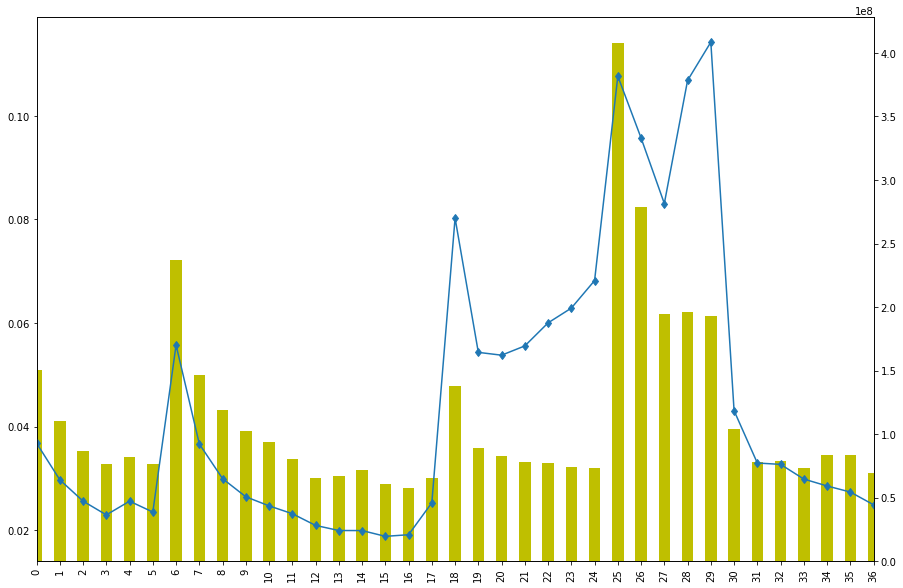

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()
pur_daily['price_sum'].plot(kind='bar', color='y', ax=ax1)
pur_daily['pur'].plot(kind='line', marker='d', ax=ax2)
ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

In [138]:
pur_daily.round(2).to_csv('pur_daily.csv', index=False)

In [198]:
daily_gcoin_pd = gcoin_pc.groupBy('date', 'account_id').agg(sum('price').alias('gcoin_daily_use'), 
                                        min('price').alias('min_gcoin'), 
                                        avg('price').alias('avg_gcoin'), 
                                        max('price').alias('max_gcoin'),
                                        countDistinct('transaction_id').alias('trans_time')).toPandas()

In [218]:
# 최고치로 예상 

In [206]:
account_cnt_500 = daily_gcoin_pd[(daily_gcoin_pd.gcoin_daily_use >= 500) & (daily_gcoin_pd.gcoin_daily_use < 3000)].groupby('date')['account_id'].count().reset_index(name='500').sort_values('date')
account_cnt_3000= daily_gcoin_pd[(daily_gcoin_pd.gcoin_daily_use >= 3000) & (daily_gcoin_pd.gcoin_daily_use < 5000)].groupby('date')['account_id'].count().reset_index(name='3000').sort_values('date')
account_cnt_5000 = daily_gcoin_pd[daily_gcoin_pd.gcoin_daily_use >= 5000].groupby('date')['account_id'].count().reset_index(name='5000').sort_values('date')

In [207]:
a = pd.merge(account_cnt_500, account_cnt_3000, on='date')
a = pd.merge(a, account_cnt_5000, on='date')
a.head()

,date,500,3000,5000
0,2021-09-11,36578,4746,6199
1,2021-09-12,29476,3636,4421
2,2021-09-13,21245,2522,3486
3,2021-09-14,18356,2150,3056
4,2021-09-15,18739,2325,3448


In [208]:
a['emote'] = a['500'] * 4.99
a['bundle'] = a['3000'] * 31.99
a['mega'] = a['5000'] * 59.99

In [212]:
a[['emote', 'bundle', 'mega']].sum()

emote     5282663.50
bundle    2945479.25
mega      9978436.65
dtype: float64

In [216]:
a[['emote', 'bundle', 'mega']].sum().values.sum()

18206579.4

In [229]:
a.to_csv('pc_predicted_max.csv', index=False)

In [219]:
# 최저치 예상

In [220]:
account_cnt_emote = daily_gcoin_pd[(daily_gcoin_pd.gcoin_daily_use >= 500) & (daily_gcoin_pd.gcoin_daily_use < 1000)].groupby('date')['account_id'].count().reset_index(name='500').sort_values('date')
account_cnt_bundle = daily_gcoin_pd[(daily_gcoin_pd.gcoin_daily_use >= 3000) & (daily_gcoin_pd.gcoin_daily_use < 3500)].groupby('date')['account_id'].count().reset_index(name='3000').sort_values('date')
account_cnt_mega = daily_gcoin_pd[(daily_gcoin_pd.gcoin_daily_use >= 5500)].groupby('date')['account_id'].count().reset_index(name='5500').sort_values('date')

In [221]:
b = pd.merge(account_cnt_emote, account_cnt_bundle, on='date')
b = pd.merge(b, account_cnt_mega, on='date')
b.head()

,date,500,3000,5500
0,2021-09-11,21948,1495,5194
1,2021-09-12,17729,1200,3612
2,2021-09-13,12501,811,2910
3,2021-09-14,10853,685,2563
4,2021-09-15,10764,691,2846


In [222]:
b['emote'] = b['500'] * 4.99
b['bundle'] = b['3000'] * 31.99
b['mega'] = b['5500'] * 59.99

In [225]:
b[['emote', 'bundle', 'mega']].sum()

emote     3101424.72
bundle     933436.21
mega      7462935.97
dtype: float64

In [226]:
b[['emote', 'bundle', 'mega']].sum().values.sum()

11497796.900000002

In [228]:
b.to_csv('pc_predicted_min.csv', index=False)

In [64]:
pur_weekly = pd.merge(pc_au_weekly_pd, pc_gcoin_weekly_pd, on='week')

In [65]:
pur_weekly['pur'] = pur_weekly.pu/pur_weekly.au
pur_weekly['arpu'] = pur_weekly.au/pur_weekly.price_sum
pur_weekly['arppu'] = pur_weekly.pu/pur_weekly.price_sum

In [66]:
pur_weekly

,week,au,pu,price_sum,free_sum,paid_sum,pur,arpu,arppu
0,week1,3516815,246487,819512080,141155929,691743051,0.070088,0.004291,0.000301
1,week2,3769736,227062,675274430,99828810,583778830,0.060233,0.005583,0.000336
2,week3,3547309,314815,566004180,104345780,469295960,0.088748,0.006267,0.000556
3,week4,3612634,552997,1183107800,301285950,890699450,0.153073,0.003054,0.000467
4,week5,3254344,491315,806791430,224796715,589921655,0.150972,0.004034,0.000609
5,week6,2003704,71020,152124940,26156400,128097710,0.035444,0.013171,0.000467


In [ ]:
# df_meta = mysql.read_table(spark, 'metainfo', 'item_meta_sales')
# df_meta.show(5, False)